# Numerical integration: introduction

This notebook is based on Chapters 7 and 10 of 

<a id="thebook"></a>
> Süli, Endre and Mayers, David F. _An introduction to numerical analysis_. Cambridge University Press, Cambridge, 2003.
<https://doi.org/10.1017/CBO9780511801181> (ebook in [Helka](https://helka.helsinki.fi/permalink/358UOH_INST/1h3k2rg/alma9926836783506253))

We know how to evaluate some simple integrals of elementary functions by pen and paper but, in general, symbolic evaluation of integrals is a complicated problem, see for example the Wikipedia article of on the [Risch algorithm](https://en.wikipedia.org/wiki/Risch_algorithm). Here we consider numerical evaluation of integrals, a much simpler problem.

In [ ]:
import sympy as sp
from sympy.abc import x
from IPython.display import Math

def display_risch(f):
    int_tex = r'\int ' + sp.latex(f)  + ' dx'
    F = sp.integrate(f, x, risch=True)
    if not isinstance(F, sp.integrals.Integral):
        # The integral is elementary and we display the antiderivative
        display(Math(int_tex + '=' + sp.latex(F)))
    elif isinstance(F, sp.integrals.risch.NonElementaryIntegral):
        # The integral is proven to be nonelementary by the algorithm, 
        # meaning the integral cannot be represented using a combination of 
        # exponentials, logarithms, trig functions, powers, rational functions, 
        # algebraic functions, and function composition
        display(Math(int_tex + r'\,\text{ is not an elementary function}'))
    else:
        # The version implemented in SymPy only supports a small subset of 
        # the full Risch algorithm, no conclusion can be drawn from this case
        display(Math(int_tex + r'\,\text{ can not be handled by the algorithm}'))

In [ ]:
# Example from pp. 82-84 (Examples 2 and 3) of
#   Grozin, A. Introduction to Mathematica for Physicists. Springer, 2014.
# shows that a small change in the integrand makes it impossible to express 
# an integral by using elementary functions      
display_risch(sp.log(x)/x)
display_risch(sp.log(x)/(x + 1))
# Example in the Wikipedia article on the Risch algorithm
display_risch(x / sp.sqrt(x**4 + 10*x**2 - 96*x - 72))

# Newton-Cotes formulae

The _Newton-Cotes formula_ of order $n = 1, 2, \dots$ is obtained by letting $p \in \mathbb P_n$ be the Lagrange interpolation polynomial of a function $f$ at $a = x_0 < x_1 < \dots < x_n = b$ on an interval $[a,b]$, and approximating

$$
\int_a^b f(x) dx \approx \int_a^b p(x) dx.
$$

Recall that 

$$
p(x) = \sum_{k=0}^n f(x_k) L_k(x),
$$

where $L_k \in \mathbb P_n$ are the polynomials satisfying $L_k(x_i) = \delta_{ki}$.
Hence

$$
\int_a^b p(x) dx = \sum_{k=0}^n w_k f(x_k), \qquad w_k = \int_a^b L_k(x) dx.
$$

In [ ]:
import numpy as np
import scipy.interpolate as interp

def nc_weights_demo(a, b, n):
    '''Compute the quadrature weights for Newton-Cotes formula of order n on [a, b]'''
    N = n+1
    xs = np.linspace(a, b, N) # uniform grid 
    ws = np.zeros(N)
    for k in range(N):
        ys = np.zeros(N)
        ys[k] = 1
        l = interp.lagrange(xs, ys) # L_k
        L = np.polyint(l)
        ws[k] = L(b) - L(a)
    return ws, xs

def integrate(ws, xs, f):
    '''Integrate f using the quadrature weights ws and points xs'''
    return np.sum(ws * f(xs))

In [ ]:
a, b = 0, 1
def test_integrate(ws, xs, expr):
    # Convert a symbolic expression with x as a free variable to a function 
    f = sp.lambdify(x, expr) 
    display(Math(r'\text{' + 
        f'Integrate gives {integrate(ws, xs, f):.2f} ' 
        r' for }\int' + f'_{a}^{b}' + sp.latex(expr)  + 
        f' dx = {sp.integrate(expr, (x, a, b))}')) 

n = 1
ws_demo, xs = nc_weights_demo(a, b, n)
test_integrate(ws_demo, xs, 1)
test_integrate(ws_demo, xs, x)
test_integrate(ws_demo, xs, x**2)

In [ ]:
n = 2
ws_demo, xs = nc_weights_demo(a, b, n)
fs = [x**n for n in range(5)]
for f in fs:
    test_integrate(ws_demo, xs, f)

from scipy import integrate as integ
ws_scipy, _ = integ.newton_cotes(n, equal=1)
ws_scipy *= (b-a)/n
print('Using SciPy')
test_integrate(ws_scipy, xs, fs[-1])

<div style="padding:25px; border: 2px solid gray;">

## Theorem: error in Newton-Cotes

Let $n=1,2,\dots$ and $f \in C^{n+1}(a,b)$. Let $w_i, x_i$, $i=0,\dots,n$, be the quadrature weights and points in the Newton-Cotes formula of order $n$ on $[a,b]$. Then

\begin{align*}
&\left|\int_a^b f(x) dx - \sum_{k=0}^n w_k f(x_k) \right| 
\\&\quad\le 
\frac{\|f^{(n+1)}\|_\infty}{(n+1)!} \int_a^b |x-x_0| \times \dots \times |x-x_n| dx.
\end{align*}
</div>

For a proof, see Theorem 7.1 in [the book](#thebook). The Newton-Cotes formula of order $n$ is exact (that is, it gives the exactly correct integral) for polynomials of degree $n$. When $n$ is even and the grid is uniform, it is exact also for polynomials of degree $n+1$, leading to a better estimate than that in the theorem. For the sharp estimate in the case $n=2$, see Theorem 7.2 in [the book](#thebook).

In [ ]:
def nc_weights_sym(n):
    '''Compute symbolically the weights for Newton-Cotes formula of order n'''
    from sympy.abc import a, b, x
    ws = []
    h = (b - a)/n
    xs = [sp.simplify(a + k*h) for k in range(n+1)]
    for k in range(len(xs)):
        L = 1
        for i in range(len(xs)):
            if i != k:
                L *= (x - xs[i]) / (xs[k] -xs[i])
        ws.append(sp.simplify(sp.integrate(L, (x, a, b))))
    return ws, xs

def nc_formula(n):
    '''Compute symbolic expression for Newton-Cotes formula of order n'''
    w, x = nc_weights_sym(n)
    f = sp.Function('f')
    nc_form = 0
    for k in range(len(w)):
        nc_form += w[k] * f(x[k])
    return sp.simplify(nc_form)

In [ ]:
print('Trapezium rule')
display(Math(sp.latex(nc_formula(1))))
print("Simpson's rule")
display(Math(sp.latex(nc_formula(2))))

Recall that the Lagrange interpolation polynomial of 

$$
f(x) = \frac{1}{1+x^2}
$$

gives a poor approximation of $f$ on $[-5, 5]$ due to the Runge phenomenon. 

Thus the Newton-Cotes formulae are expected to work poorly for 

$$
\int_{-5}^5 f(x) dx.
$$

In [ ]:
def f(x):
    return 1 / (1 + x**2)
ns = range(2, 13, 2)
N = np.size(ns)
data = np.zeros(N)
for k in range(N):
    ws, xs = nc_weights_demo(-5, 5, ns[k])
    data[k] = integrate(ws, xs, f)

import pandas as pd
df = pd.DataFrame(data)
df.columns = ['$I_n$']
df.index = ns
df.index.name = 'n'
df.style.format('{:.5f}')

# Composite formulae

Analogously to splines, we will use a division to small subintervals.

Let $a = x_0 < x_1 < \dots < x_n = b$ be equally spaced
and write $h = (b-a)/n$ for the spacing. For $f \in C(a,b)$ there holds

$$
\int_a^b f(x) dx = \sum_{i=1}^n \int_{x_{i-1}}^{x_i} f(x) dx.
$$

We approximate using the trapezium rule

$$
\int_{x_{i-1}}^{x_i} f(x) dx \approx \frac{x_i - x_{i-1}}{2}(f(x_{i-1}) + f(x_i))
= 
\frac h 2 (f(x_{i-1}) + f(x_i)),
$$

and obtain the _composite trapezium rule_

$$
\int_a^b f(x) dx 
\approx 
h \left( \frac12 f(x_0) + f(x_1) + \dots + f(x_{n-1}) + \frac12 f(x_n) \right).
$$

<div style="padding:25px; border: 2px solid gray;">

## Theorem: error in composite trapezium rule
Let $f \in C^2(a,b)$ and write $I_h f$ for the composite trapezium rule applied to $f$ with the spacing $h>0$. Then there is $C>0$, independent of $f$ and $h$, such that

$$
\left|\int_a^b f dx - I_h f \right| \le C \|(h\partial)^2 f\|_\infty = C h^2 \|f'' \|_\infty.
$$
</div>

_Proof_. By the error in Newton-Cotes theorem,  

\begin{align*}
\left| \int_a^b f(x) dx - I_h f \right| 
\le 
\sum_{i=1}^n \left|\int_{x_{i-1}}^{x_i} f(x) dx - \frac h 2 (f(x_{i-1}) + f(x_i)) \right|
\le n \|f''\|_\infty h^3.
\end{align*}

The claim follows from $h = (b-a)/n$.
$\blacksquare$

## Example: Richardson extrapolation

The error of the composite trapezium rule with $n$ intervals of length $h$ is
$$\Epsilon_1(f,n) = | I(f) - I_1(f,n) | \leq C h^2 + \mathcal{O}(h^3).$$

The Richardson extrapolation $R_1(f,n)$ given by two trapezium quadratures of different resolutions gives improved rate:
\begin{align*}
| I(f) - R_1(f,n) | &= \big| I(f) - \frac{1}{3} \left( 4 I_1(f,2n) - I_1(f,2)  \right) \big| \\
& \leq C h^3 + \mathcal{O}(h^4).
\end{align*}

But $2n$ intervals would also allow the use of Simpson's rule, which should have an error
$$ \Epsilon_2(f,2n) \leq \frac{(b-a)^5}{2880 n^4} \| f^{(4)} \|_\infty, $$
i.e. (since $b-a = 2nh$)
$$ \Epsilon_2(f,2n) = C h^4 + \mathcal{O}(h^5). $$

Let's try this on
$$ I(f) = \int_0^{\ln 2} 2e^{-x} dx \quad (= 1) $$
and plot the resulting errors.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

def f(x):
    return 2*np.exp(-x)

def richardson(y, x):
    # Assume y = f(x) for 2n intervals
    return 1/3*(4*np.trapz(y, x) - np.trapz(y[0::2], x[0::2]))

a, b = 0, np.log(2)
I = 1 # True value

ns = 2*5**np.array(range(4)) # Even number of intervals only!
eTrapz = np.zeros(len(ns))
eRich = np.zeros(len(ns))
eSimps = np.zeros(len(ns))

for i, n in enumerate(ns):
    x = np.linspace(a, b, n+1, endpoint=True)
    y = f(x) # Evaluate on dense grid

    eTrapz[i] = np.abs(I - np.trapz(y, x))
    eRich[i] = np.abs(I - richardson(y, x))
    eSimps[i] = np.abs(I - scipy.integrate.simpson(y, x))

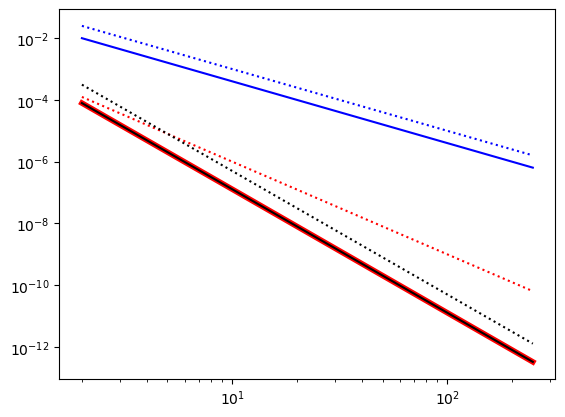

In [53]:
# Logarithmic plots should reveal the exponents of the error decay
plt.loglog(ns, eTrapz, 'b')
plt.loglog(ns, eRich, 'r', lw=4)
plt.loglog(ns, eSimps, 'k')

hs = 1/ns
# Multiplying by a constant shifts the h^k plots vertically
plt.loglog(ns, 0.1*hs**2, ':b')
plt.loglog(ns, 0.001*hs**3, ':r')
plt.loglog(ns, 0.005*hs**4, ':k');

In this particular case we obtain as good of an approximation as with the Simpson's method. Remember that the error estimates are *worst case* estimates and often quite loose ones.

# Gaussian quadrature

The Gaussian quadrature is an approximation of the form 

\begin{align*}
\int_a^b f(x) dx = \sum_{k=0}^n w_k f(x_k)
\end{align*}

where the quarature points $x_k \in [a,b]$ and weights $w_k$ are chosen so that the formula is exact for polynomials up to degree $2n + 1$. 

In order to construct the points and weights we need to study Hermite interpolation that reads

> Let $x_i, y_i, z_i \in \mathbb R$, $i=0,\dots,n$, and suppose that $x_i \ne x_j$ for $i \ne j$.
>
> Find $p \in \mathbb P_{2n +1}$ such that $p(x_i) = y_i$ and $p'(x_i) = z_i$ for all $i=0,\dots,n$.

<div style="padding:25px; border: 2px solid gray;">

## Theorem: Hermite interpolation
Let $n \ge 0$ be an integer let $x_i \in \mathbb R$, $i=0,\dots,n$, be distinct. 
Then for any $y_i, z_i \in \mathbb R$, $i=0,\dots,n$, there is a unique $p \in \mathbb P_{2n+1}$ 
such that $p(x_i) = y_i$ and $p'(x_i) = z_i$ for all $i=0,\dots,n$. 
</div>

For a proof, see Theorem 6.3 in [the book](#thebook).

<div style="padding:25px; border: 2px solid gray;">

## Theorem: error in Hermite interpolation
Let $x_0, \dots x_n \in [a,b]$ be distinct, let $f \in C^{2n+2}(a,b)$, and 
let $p \in \mathbb P_{2n+1}$ be the Hermite interpolation polynomial of $f$, that is, 

\begin{align*}
p(x_i) = f(x_i), \quad p'(x_i) = f'(x_i), \qquad i=0,\dots,n.
\end{align*}

Then for all $x \in [a,b]$ there is $\xi \in (a,b)$ such that 

\begin{align*}
f(x) - p(x) = \frac{f^{(2n+2)}(\xi)}{(2n+2)!} \prod_{i=0}^n (x-x_i)^2.
\end{align*}
</div>

For a proof, see Theorem 6.4 in [the book](#thebook).

Let $f \in C^{2n+2}(a,b)$, let 

\begin{align*}
p(x) = \sum_{k=0}^n f(x_k) H_k(x) + \sum_{k=0}^n f'(x_k) K_k(x)
\end{align*}

be its Hermite interpolation polynomial, and consider the approximation 

\begin{align*}
\int_a^b f(x) dx \approx \int_a^b p(x) dx = \sum_{k=0}^n w_k f(x_k) + \sum_{k=0}^n \tilde w_k f'(x_k),
\end{align*}

where

\begin{align*}
w_k = \int_a^b H_k(x) dx, \quad \tilde w_k = \int_a^b K_k(x) dx.
\end{align*}

The idea of the Gaussian quadrature is to choose the points $x_k$ so that $\tilde w_k = 0$ for all $k=0,\dots,n.$

Using 

\begin{align*}
K_k(x) = L_k^2(x) (x - x_k), \quad L_k(x) = \prod_{i=0, i \ne k}^n \frac{x-x_i}{x_k-x_i}, \qquad k=0,\dots,n,
\end{align*}

we have

\begin{align*}
\tilde w_k = \int_a^b K_k(x) dx = c_n \int_a^b L_k(x) \pi(x) dx,
\end{align*}

where

\begin{align*}
\pi(x) = \prod_{i=0}^n (x-x_i),\quad c_n = \prod_{i=0, i \ne k}^n \frac{1}{x_k-x_i}.
\end{align*}

(In the case $n=0$, the formula holds with $c_n = 1$.) We see that $\tilde w_k = 0$ if $\pi \in \mathbb P_{n+1}$ is orthogonal to all polynomials in $\mathbb P_{n}$ in the sense of $L^2(a,b)$.

In the case that $a=-1$ and $b=1$, the [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) $P_n \in \mathbb P_n$, $n=0,1,\dots$, are orthogonal with respect to the inner product $L^2(a,b)$. The points $x_i$, $i=0,\dots,n$ are chosen as the roots of $P_{n+1}$.

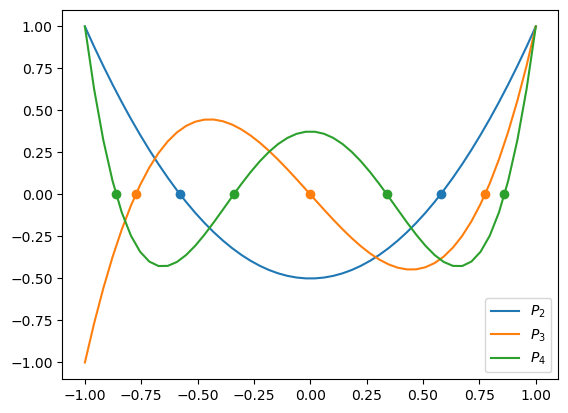

In [3]:
from numpy.polynomial import legendre as leg
from matplotlib import pyplot as plt

xs_plot = np.linspace(-1,1)
for n in range(1, 4):
    cs = np.zeros(n + 2)
    cs[-1] = 1
    plt.plot(xs_plot, leg.legval(xs_plot, cs), label=f'$P_{n+1}$')
    roots = leg.legroots(cs)
    plt.scatter(roots, np.zeros(len(roots)))
plt.legend();

The case of arbitrary $a < b$ can be reduced to the case $a = -1$ and $b = 1$ by the change of variable

\begin{align*}
y = \frac{b - a} 2 x + \frac{a + b}2.
\end{align*}

Note that $x=-1$ corresponds to $y = a$ and $x = 1$ to $y = b$. Hence

\begin{align*}
\int_a^b f(y) dy 
&= \frac{b - a} 2 \int_{-1}^1 f(\frac{b - a} 2 x + \frac{a + b}2) dx
\\&\approx \sum_{k=0}^n \frac{b - a} 2 w_k f(\frac{b - a} 2 x_k + \frac{a + b}2),
\end{align*}

where $w_k$ and $x_k$ are the quadrature weights and points on $[-1,1]$.

In [ ]:
def change_of_interval(x, a, b):
    return (b - a)/2 * x + (a + b)/2

a, b = 0, 1
n = 1

xs, ws = leg.leggauss(n + 1)
ys = change_of_interval(xs, a, b)
ws *= (b - a) / 2

fs = [x**n for n in range(5)]
for f in fs:
    test_integrate(ws, ys, f)

<div style="padding:25px; border: 2px solid gray;">

## Theorem: error in Gaussian quadrature

Let $n=1,2,\dots$ and $f \in C^{2n+2}(a,b)$. 
Let $w_i, x_i$, $i=0,\dots,n$, be the quadrature weights and points in the Gaussian quadrature of order $n$ on $[a,b]$. Then

\begin{align*}
&\left|\int_a^b f(x) dx - \sum_{k=0}^n w_k f(x_k) \right| 
\\&\quad\le 
\frac{\|f^{(2n+2)}\|_\infty}{(2n+2)!} \int_a^b (x-x_0)^2\dots(x-x_n)^2 dx.
\end{align*}
</div>

# On the integration sub-package of SciPy

The composite formulae are well-suited for approximation of integrals when the integrand is known only at some points $x_i$, $i=0,\dots,n$. The composite trapezium rule is implemented by [trapezoid](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html) and its second order analogue, the composite Simpson's rule, by [simpson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simpson.html#scipy.integrate.simpson).

For highly regular grids $x_i$, $i=0,\dots,n$, there are methods that outperform the composite rules. If the samples are equally-spaced and the number of samples is $2^k + 1$ for some integer $k=1,2,\dots$, then Romberg integration (which is based on Richardson extrapolation) [romb](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.romb.html#scipy.integrate.romb) can be used to obtain high-precision estimates of the integral using the available samples. This method is described in Section 7.7 of [the book](#thebook).

If the integrand can be evaluated at any point on the region of integration, then [quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) can be used. This calls the Fortran library [QUADPACK](https://en.wikipedia.org/wiki/QUADPACK). The main focus of this library is on automatic integration in which the algorithm attempts to perform an integration with an error no larger than that requested. The library uses an [adaptive quadrature](https://en.wikipedia.org/wiki/Adaptive_quadrature) that divides the region of integration into adaptively refined subintervals. Generally, adaptive algorithms are just as efficient as composite rules for smooth integrands, but they may work for non-smooth integrands for which traditional algorithms may fail. 

For more details on integration with SciPy see the [tutorial](https://docs.scipy.org/doc/scipy/tutorial/integrate.html).

In [ ]:
import scipy.integrate as integ
def f(x):
    return np.log(x)/(x+1)
a, b = 1, 2

xs = np.linspace(a, b)
ys = f(xs)
print(f'trapezoid gives {integ.trapezoid(ys, xs)}')
print(f'simpson gives   {integ.simpson(ys, xs)}')

xs, dx = np.linspace(a, b, 33, retstep=True)
ys = f(xs)
print(f'romb gives      {integ.romb(ys, dx)}')

# quad returns also an estimate of the absolute error in the result
print(f'quad gives     {integ.quad(f, a, b)}')

In [ ]:
def f(x):
    return 1/np.sqrt(x)
a, b = np.finfo(float).eps, 1

xs = np.linspace(a, b)
ys = f(xs)
print(f'trapezoid gives {integ.trapezoid(ys, xs)}')
print(f'simpson gives   {integ.simpson(ys, xs)}')

xs, dx = np.linspace(a, b, 33, retstep=True)
ys = f(xs)
print(f'romb gives      {integ.romb(ys, dx)}')

print(f'quad gives     {integ.quad(f, a, b)}')

print(f'correct value   2 (up to machine precision)')